<h1> Create a Faster-RCNN Object Detection Model with SAS DLPy  </h1>

This notebook uses SAS DLPy to create a SAS Deep Learning Faster-RCNN object detection model. The Faster R-CNN network is a multi-task learning model that uses both a region proposal layer and a FastRCNN layer to perform object detection predictions. 

The overal Faster-RCNN model architecture consists of the following:

 - a CNN backbone network
 - two special convolutional layers (extracts features for the region proposal layer)
 - a region proposal layer
 - an RoI pooling Layer
 - several fully connected layers 
 - a FastRCNN layer (classifies the objects that were detected in RoIs, and detects a more accurate location for the object).


 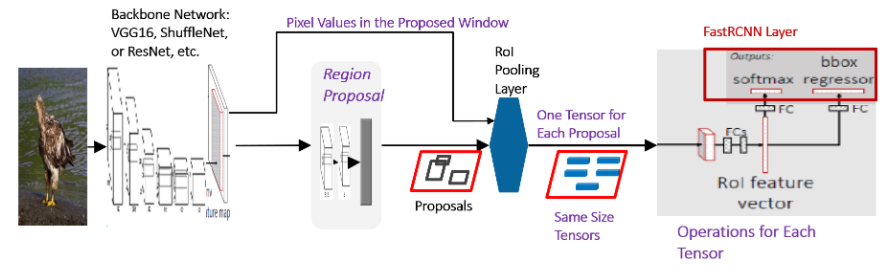

The network begins by using multiple CNN layers to extract feature maps from each image. The region proposal network generates multiple windows that are highly likely to contain an object. Then the FasterRCNN algorithm retrieves the feature maps inside each window, resizes (or pools) them into fixed sizes (RoI pooling), predicts the class probability, and creates a more accurate bounding box for the object.

The FasterRCNN algorithm does not generate anchor boxes from data. Instead, it uses fixed size anchor shapes selected to cover main object shapes and sizes. Instead of performing a classification on many object categories, the region propopsal network in FasterRCNN performs a binary classification on whether the window contains an object.

The example in this notebook uses SAS Viya and SAS DLPy to define, create, and train a FasterRCNN network with a VGG16 backbone. The network scores 416 x 416 color images of soccer scenes to detect, classify, and label up to three object instances per image. The model is trained to detect two object classes in an image: Player (PLA) and Ball (Ball). 

The SAS Viya FasterRCNN model in this notebook is created using the SAS DLPy FasterRCNN module. The new FasterRCNN model uses pre-trained weights to perform transfer learning. After training, the FasterRCNN model scores the test data by detecting objects, enclosing them in boundary boxes, and labeling the detected images. 

### Table of Contents 
- [Important Note: Client and Server Definitions](#ClientServer)
- [Prepare Resources and Configure Environment for Modeling](#getReady)
    - [Download the FasterRCNN Example Model Data](#downloadData)
    - [Download the Pre-trained Model Weights](#downloadWeights)
    - [Import Required Python and SAS DLPy Modules](#importPythonDLPy)
- [Launch SAS CAS and Load the SAS DLPy FasterRCNN Library](#startCAS)
- [Define and Create a Faster RCNN Model](#defineRCNN)
- [Load the Model Training Data into CAS](#loadTrainData)
    - [Define Caslib 'RCNN' and Initialize Model Variables](#defineCaslib)
    - [Create Training Data Partition and Load into SAS CAS](#createTrainPartition)
    - [Inspect and Validate the Train Table Images](#inspectImages)
- [Load the Test Data](#loadTest)
    - [Initialize Test Model Variables](#initVars)
    - [Extract and Load the Test Data in CAS](#extractLoad)
- [Visualize the Training Data With Detected Objects and Labels](#visualizeTrainData)
- [Load Pretrained Model Weights into SAS CAS](#loadWeights)
- [Define and Create Target Columns for the Test Data](#defineTargetCols)
- [Train the FasterRCNN Model](#trainModel)
- [Score the Test Data using FasterRCNN Model](#scoreTestData)
    - [Show Detected Objects in the Scored Test Data](#showDetected)


<a id="ClientServer"></a>

### Important Note: Client and Server Definitions
SAS Viya literature and technical documentation often refers to client and server entities. In this scenario, the client is the computer that runs the Jupyter notebook with the example code. The server is the computer that is running the Viya server. These two computers might (or might not) use the same operating system, and might (or might not) have access to a common file system.

In [1]:
# This code defines variables for path specifications to  
# server-side directories for model image, weight, and label files.

# Server path to FasterRCNN example files (your path will be different)
server_model_path = r'/your-network/path-to/FastRCNN-example-data'

<a id="getReady"></a>

### Prepare Resources and Configure Computing Environment for Modeling

Use this section to organize all of the resources that you will need and configure your local computing environment for this notebook example. Performing these tasks in advance means you can run the example without multiple stops to locate and download necessary resources. This approach enables you to focus on how to use SAS DLPy to complete the modeling task in this notebook.

<a id="downloadData"></a>

#### Download the FasterRCNN Example Model Data

This example notebook uses a SAS-generated data set to generate the required train and score data sets. The input data is a collection of 4,554 images in .jpg format. Each input data record contains bounding box, label, and class category information for up to 3 detected objects. 

Download the archived SAS model data [Obj_Det_Soccer_Images_416.zip](https://support.sas.com/documentation/prod-p/vdmml/zip/Obj_Det_Soccer_Images_416.zip) from the [SAS Viya Deep Learning Models and Tools](https://support.sas.com/documentation/prod-p/vdmml/zip/index.html) support page. 

From the archive, extract the input data file `Soccer_Images_416.sashdat` and save it to the server location that you specified previously for the variable `server_model_path`.


<a id="downloadWeights"></a>

#### Download the Pre-trained Model Weights   

SAS DLPy enables you to use pre-trained model weights with deep learning models that you import or create. This FasterRCNN model performs transfer learning using an object detection model weights file and a corresponding model weight attribute labels file.  

Download the archived model weights file [Obj_Det_Soccer_Weights](https://support.sas.com/documentation/prod-p/vdmml/zip/Obj_Det_Soccer_Weights.zip) from the SAS Viya [Deep Learning Models and Tools page](https://support.sas.com/documentation/prod-p/vdmml/zip/index.html).

Expand the archive and save the weights file `VGG16_YOLO_Weight_Attr_Label.sashdat` and the weight attribute labels file `VGG16_YOLO_Attr_Full_Labels.sashdat` to the server location that you specified earlier for `server_model_path`. 

<a id="importPythonDLPy"></a>

#### Import Required Python and SAS DLPy Modules

After copying the input image and pre-trained weight data to your server, configure your client computing environment for the analytic task. 

Import the various Python utilities and SAS DLPy modules that this notebook uses. 

The SAS Scripting Wrapper for Analytic Transfer (SWAT) is the Python interface to SAS CAS. You can find more detailed information about starting a SAS CAS session with the SWAT package [here](https://sassoftware.github.io/python-swat/getting-started.html). 

In [2]:
# Import SAS SWAT and SWAT libraries
import swat as sw
from swat import *

# Import prettyprint plot utilities
from pprint import pprint

# Import matplotlib 
import matplotlib
# Display matplotlib output in notebook cells
%matplotlib inline

# Import sys module for OS interaction
import sys

# Import SAS DLPy model building libraries
from dlpy.network import *
from dlpy.layers import *
from dlpy.model import *
from dlpy.images import ImageTable
from dlpy.sequential import Sequential
from dlpy.utils import display_object_detections, plot_anchors

<a id="startCAS"></a>

### Launch SAS CAS and Load the SAS DLPy FasterRCNN Library

Connect to your SAS CAS server and specify your CAS portID. SAS examples use port 5570 by default, but you can substitute a port number of your own choosing.


In [3]:
# Connect to the SAS CAS Server
s=CAS('your-host-name.unx.company-name.com', 5570)

In [4]:
# Import the SAS DLPy Faster_RCNN model library
from dlpy.applications import Faster_RCNN

<a id="defineRCNN"></a>

### Define and Create a Faster RCNN Model 


After launching SAS CAS and importing the SAS DLPY FasterRCNN model library, specify the FasterRCNN network architecture components and specify required FasterRCNN model library parameters.

The FasterRCNN network is organized as shown below:

In [5]:
# Specify FasterRCNN network parameters 

# Input and scored Image Dimensions
# These values are also used in anchor ratio formulas

# Height
imH=416

# Width
imW=416

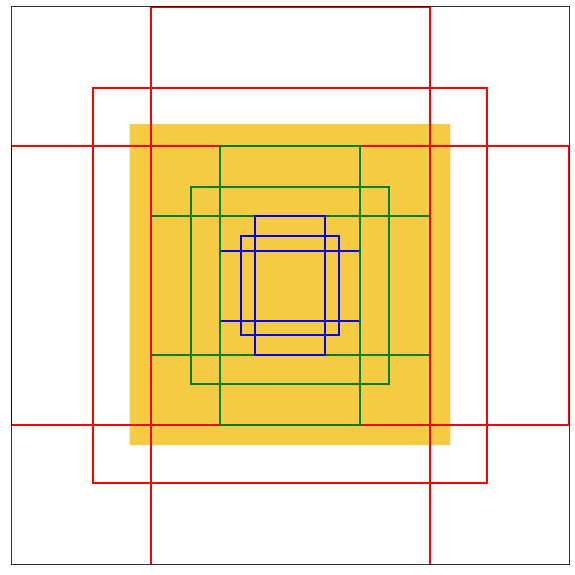

In [6]:
# Specify Anchor settings for the Region Proposal Layer 

# base anchor size
base_anchor_size = 16


# Feature map anchor scales for base anchor size
# Detect objects using multiple scales
anchor_scale = [8, 16, 32]

# anchor height and width ratios (h/w) used
# anchor ratio
anchor_ratio = [0.5, 1, 2]

# draw anchor boxes
plot_anchors(base_anchor_size=base_anchor_size, 
             anchor_scale=anchor_scale, 
             fig_size=(10, 60),
             anchor_ratio=anchor_ratio, 
             image_size = (imH, imW))

In [7]:
# Create and compile the SAS Viya FasterRCNN model 
# named 'soccer' using the SAS DLPy Faster_RCNN library. 
# There are 2 object classes (Ball and Player). 
# Model image size is 416 pixels x 416 pixels.

soccer = Faster_RCNN(s, 
                     n_classes=2, 
                     
# coordinate type                     
                    coord_type='yolo', 
# network image dimensions                     
                    width=imW, 
                    height=imH
                   )

NOTE: Model compiled successfully.


In [8]:
# Use print_summary() to display a table depicting
# the FasterRCNN model layer architecture.

soccer.print_summary()

Layer Id         Layer            Type   Kernel Size  Stride Activation  \
0         0          data           input                             None   
1         1       conv1_1           convo        (3, 3)  (1, 1)       Relu   
2         2       conv1_2           convo        (3, 3)  (1, 1)       Relu   
3         3         pool1            pool        (2, 2)  (2, 2)        Max   
4         4       conv2_1           convo        (3, 3)  (1, 1)       Relu   
5         5       conv2_2           convo        (3, 3)  (1, 1)       Relu   
6         6     Pooling_2            pool        (2, 2)  (2, 2)        Max   
7         7       conv3_1           convo        (3, 3)  (1, 1)       Relu   
8         8       conv3_2           convo        (3, 3)  (1, 1)       Relu   
9         9       conv3_3           convo        (3, 3)  (1, 1)       Relu   
10       10     Pooling_3            pool        (2, 2)  (2, 2)        Max   
11       11       conv4_1           convo        (3, 3)  (1, 1)       Relu   
12       12       conv4_2           convo        (3, 3)  (1, 1)       Relu   
13       13       conv4_3           convo        (3, 3)  (1, 1)       Relu   
14       14     Pooling_4            pool        (2, 2)  (2, 2)        Max   
15       15       conv5_1           convo        (3, 3)  (1, 1)       Relu   
16       16       conv5_2           convo        (3, 3)  (1, 1)       Relu   
17       17       conv5_3           convo        (3, 3)  (1, 1)       Relu   
18       18  rpn_conv_3x3           convo        (3, 3)  (1, 1)       Relu   
19       19     rpn_score           convo        (1, 1)  (1, 1)   Identity   
20       20          rois  regionproposal                             Auto   
21       21   roi_pooling      roipooling                             Auto   
22       22           fc6              fc  (1274, 4096)               Relu   
23       23           fc7              fc  (4096, 4096)               Relu   
24       24     cls_score              fc     (4096, 3)           Identity   
25       25     bbox_pred              fc    (4096, 12)           Identity   
26       26      fastrcnn        fastrcnn                             Auto   
27                                                                           
28  Summary                                                                  

        Output Size        Number of Parameters FLOPS(forward pass)  
0     (416, 416, 3)                      (0, 0)                   0  
1    (416, 416, 64)                  (1728, 64)           299040768  
2    (416, 416, 64)                 (36864, 64)          6379536384  
3    (208, 208, 64)                      (0, 0)                   0  
4   (208, 208, 128)                (73728, 128)          3189768192  
5   (208, 208, 128)               (147456, 128)          6379536384  
6   (104, 104, 128)                      (0, 0)                   0  
7   (104, 104, 256)               (294912, 256)          3189768192  
8   (104, 104, 256)               (589824, 256)          6379536384  
9   (104, 104, 256)               (589824, 256)          6379536384  
10    (52, 52, 256)                      (0, 0)                   0  
11    (52, 52, 512)              (1179648, 512)          3189768192  
12    (52, 52, 512)              (2359296, 512)          6379536384  
13    (52, 52, 512)              (2359296, 512)          6379536384  
14    (26, 26, 512)                      (0, 0)                   0  
15    (26, 26, 512)              (2359296, 512)          1594884096  
16    (26, 26, 512)              (2359296, 512)          1594884096  
17    (26, 26, 512)              (2359296, 512)          1594884096  
18    (26, 26, 512)              (2359296, 512)          1594884096  
19     (26, 26, 54)                 (27648, 54)            18690048  
20         (5, 128)                      (0, 0)                   0  
21       (7, 7, 26)                      (0, 0)                   0  
22             4096                (5218304, 0)     

<a id="loadTrainData"></a>

### Load the Model Training Data into CAS

First, create a SAS caslib named `rcnn` for the notebook project files. Next, filter and extract the training data partition.

<a id="defineCaslib"></a>

#### Define Caslib rcnn and Initialize Model Variables

In [9]:
# Define SAS caslib rcnn for the project data

# Use the 'server_model_path' variable that points 
# to the project file directory

# Create caslib rcnn 
s.table.addcaslib(activeonadd=False,
                  datasource={'srctype':'path'}, 
                  name='rcnn',
                  path=server_model_path,
                  subdirectories=True)

# Initialize new varsiables 'coordType' and 'maxobjs'

# coordType value is used later to select 
# YOLO-style output column headings
coordType = 2;

NOTE: Cloud Analytic Services added the caslib 'rcnn'.


<a id="createTrainPartition"></a>

#### Create Training Data Partition and Load into SAS CAS

The input source file `Soccer_Images_416.sashdat` is used to generate both train and test data partitions for the model. The train and test partitions reflect a 55/45 split. 

The code below creates the training partition by using a where-clause filter on the downloaded `Soccer_Images_416.sashdat` file. The training data set contains 416 x 416 color images, as well as metadata for up to three detected objects per image: object location coordinates, object bounding box coordinates, and object label. 

Load the train data set `trainSet` in caslib `rcnn`. Next, create an imageTable `trainSetTbl`. Use `trainSetTbl` to visually explore and validate the images in CAS table `trainSet` prior to model training. 

In [10]:
# Generate the training data set.

# For the first 2000 indexed observations, select 
# all obesrvations that contain data with at 
# least 1 detected object. 
whereStr = "_nObjects_>0 and _id_ < 2000"

# load the filtered observations and create SAS CAS 
# table 'trainSet' in caslib rcnn

# Save CAS table 'trainSet' as a Python object 'train_set'
# to enable the use of Python commands with the CAS table.
train_set = s.table.loadtable(casout={'name':'trainSet', 
                                      'replace':True, 
                                      'blocksize':350},
                                      caslib='rcnn',    
                  
# The SAS soccer data set with detected objects and labels (226MB)                            
                                      path='Soccer_Images_416.sashdat',   

# End the where-clause filter
                                      where=whereStr).casTable
                 
# Create ImageTable 'trainSetTbl' using the Python variable 'train_set' 
# for the CAS table 'trainSet' 

# Note: The imageTable 'trainSetTbl' is used in order to inspect and verify 
# the raw input data image contents and dimensions. It is not used for training.
trainSetTbl = ImageTable.from_table(train_set)

# Use Python functions _print()_ and _len()_ to display
# the number of images in the imageTable 'trainSetTbl'.
# It should be the same as are in CAS table 'trainSet'.
print(len(trainSetTbl))

# Display image attribute metadata for the input images
# Verify uniform image sizes of 416 x 416 in the data.
# Use variable 'results' to store output for display.
results = trainSetTbl.fetchImages(to=2000)
print(results.Images['Width'].value_counts())
print(results.Images['Height'].value_counts())

NOTE: Cloud Analytic Services made the file Soccer_Images_416.sashdat available as table TRAINSET in caslib CASUSER(userID).
1760
NOTE: Table IMAGEDATA_B8KDYZ contains compressed images.
416.0    1760
Name: Width, dtype: int64
416.0    1760
Name: Height, dtype: int64


Of the first 2000 indexed observations in the .sashdat input data table, 1,760 rows contained one or more detected objects and were saved in the SAS CAS table `trainSet`, and the raw images were exported to the Python imageTable `trainSetTbl` for examination. 

<a id="inspectImages"></a>

#### Inspect and Validate the Train Table Images

What does the imageTable `trainSetTbl` table look like? Use the _columninfo()_ function to display the table organization, along with the _head()_ function to display column and row contents:

In [11]:
# Display the column information for 
# the imageTable 'trainSetTbl'
trainSetTbl.columninfo()

[ColumnInfo]

         Column Label  ID              Type  RawLength  FormattedLength Format  \
 0      _image_         1  varbinary(image)      60884            60884          
 1      _label_         2           varchar          0                1          
 2  _filename_0         3           varchar         15               15          
 3         _id_         4             int64          8               19      F   
 
    NFL  NFD  
 0    0    0  
 1    0    0  
 2    0    0  
 3   19    0  

+ Elapsed: 0.00121s, user: 0.00109s, mem: 0.802mb

In [12]:
# Display the column contents for the imageTable trainSetTbl 
trainSetTbl.head(10)

Selected Rows from Table IMAGEDATA_B8KDYZ

                                             _image_ _label_      _filename_0  \
0  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...          _5407266100.jpg   
1  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...          _0466273979.jpg   
2  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...          _5452805080.jpg   
3  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...          _3839488083.jpg   
4  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...          _1238604391.jpg   
5  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...          _8394332083.jpg   
6  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...          _3378986046.jpg   
7  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...          _7664103140.jpg   
8  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...          _4147921682.jpg   
9  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...          _3622212431.jpg   

   _id_  
0   141  
1   578  
2   143  
3   232  
4   240  
5   924  
6   377  
7   278  
8   565  
9    99

Note that the image table `trainSetTbl` that was created from the SAS CAS table `train_set` is smaller in structure. The DLPy imageTable `trainSetTbl` has only 4 columns; the SAS CAS training table `train_set` has 25 columns. The imageTable contains only images and label metadata, but it can be used to visually inpect the images without annotations.  The CAS table `train_set` must be used when it is time to train the model. 

The `trainSetTbl` imageTable _image_summary_ option makes it easy to verify that all 1,760 images extracted from the source CAS table 'train_set' are uniformly 416 pixels wide by 416 pixels high in size. 

In [13]:
# Show a metadata summary for the images in 
# imageTable 'trainSetTbl'
trainSetTbl.image_summary

jpg                  1760
minWidth              416
maxWidth              416
minHeight             416
maxHeight             416
meanWidth             416
meanHeight            416
mean1stChannel     136.45
min1stChannel           0
max1stChannel         255
mean2ndChannel    128.796
min2ndChannel           0
max2ndChannel         255
mean3rdChannel     132.99
min3rdChannel           0
max3rdChannel         255
dtype: object

What do the images in the imageTable `trainSetTbl` look like?  Are the images clear and distinct? Use the _show()_ function to display a random sampling of eight images from the table. 

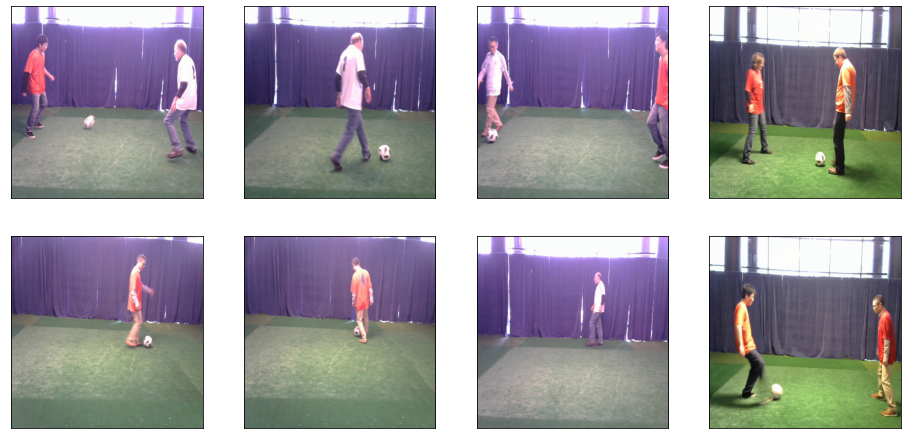

In [14]:
# Display 8 random images from the imageTable 
# 'trainSetTbl' in 4 columns 
trainSetTbl.show(nimages=8, 
                 ncol=4, 
                 randomize=True)

The images from imageTable 'trainSetTbl' are uniform in size and consistently display one or more objects that could be detected and classified as a ball or a player. These are the same images that are in the CAS training table `train_set`, except each observation in the `train_set` table also includes annotation data for _detected objects,_ _boundary boxes,_ and _labels_.

At this point, the caslib `rcnn` should contain a model file, a CAS training table, and a DLPy imageTable. Use the _tableinfo()_ function to be sure:

In [15]:
# Display a list of all of the tables currently 
# in caslib rcnn

s.table.tableInfo()

[TableInfo]

                Name  Rows  Columns  IndexedColumns Encoding  \
 0       FASTER_RCNN   464        5               0    utf-8   
 1          TRAINSET  1760       25               0    utf-8   
 2  IMAGEDATA_B8KDYZ  1760        4               0    utf-8   
 
          CreateTimeFormatted           ModTimeFormatted  \
 0  2021-01-07T23:41:30-05:00  2021-01-07T23:41:30-05:00   
 1  2021-01-07T23:41:51-05:00  2021-01-07T23:41:51-05:00   
 2  2021-01-07T23:41:51-05:00  2021-01-07T23:41:51-05:00   
 
          AccessTimeFormatted JavaCharSet    CreateTime  ...  Repeated  View  \
 0  2021-01-07T23:41:30-05:00        UTF8  1.925700e+09  ...         0     0   
 1  2021-01-07T23:41:51-05:00        UTF8  1.925700e+09  ...         0     0   
 2  2021-01-07T23:42:26-05:00        UTF8  1.925700e+09  ...         0     0   
 
    MultiPart                 SourceName  SourceCaslib  Compressed Creator  \
 0          0                                                    0  userID   
 1          0  Soccer_Images_416.sashdat          rcnn           0  userID   
 2          0                                                    0  userID   
 
   Modifier     SourceModTimeFormatted SourceModTime  
 0                                               NaN  
 1           2021-01-07T22:15:11-05:00  1.925695e+09  
 2                                               NaN  
 
 [3 rows x 23 columns]

+ Elapsed: 0.00086s, user: 0.000734s, sys: 5.2e-05s, mem: 0.686mb

There they are: 

 - FASTER_RCNN is the model table. It is a table of the model architecture and configuration settings.
 - TRAINSET is the training CAS table. It is filtered from the SGF_DetYolosgf416_0317_PLA.sashdat file, and contains detection, bounding box, and label data for each image.
 - IMAGEDATA_B8KDYZ is the imageTable created earlier to view selected columns of the training data set. 
 
What does the CAS table 'TRAINSET' ('trainSet') look like? Use the Python 'train-set' alias with the _head()_ function to dislpay the column headings:

In [16]:
# Display the headings for all 25 columns 
# in the CAS training table train_set.
train_set.head()

Selected Rows from Table TRAINSET

   _id_            imgNo  _size_  \
0   809   0307_image1359   55229   
1   810  1154_image00610   49359   
2   811   0307_image1360   55780   
3   812  1154_image00612   48904   
4   813   0307_image1361   57949   

                                          _path_ _type_ _label_ var0  \
0   /dept/cas/weshiz/SGF/0317/0307_image1359.jpg    jpg            0   
1  /dept/cas/weshiz/SGF/0317/1154_image00610.jpg    jpg            0   
2   /dept/cas/weshiz/SGF/0317/0307_image1360.jpg    jpg            0   
3  /dept/cas/weshiz/SGF/0317/1154_image00612.jpg    jpg            0   
4   /dept/cas/weshiz/SGF/0317/0307_image1361.jpg    jpg            0   

           im_path  _nObjects_ _Object0_  ...  _Object1_x  _Object1_y  \
0   0307_image1359         3.0      Ball  ...    0.326562    0.438021   
1  1154_image00610         2.0      Ball  ...    0.781641    0.350000   
2   0307_image1360         3.0      Ball  ...    0.498828    0.485417   
3  1154_image00612         2.0      Ball  ...    0.743359    0.364063   
4   0307_image1361         3.0      Ball  ...    0.614062    0.469271   

   _Object1_width  _Object1_height _Object2_  _Object2_x  _Object2_y  \
0        0.051562         0.186458       PLA    0.980469    0.531771   
1        0.061719         0.147917                   NaN         NaN   
2        0.064844         0.243750       PLA    0.228125    0.408333   
3        0.060156         0.134375                   NaN         NaN   
4        0.054688         0.146875       PLA    0.108203    0.482292   

   _Object2_width  _Object2_height  \
0        0.039062         0.188542   
1             NaN              NaN   
2        0.067187         0.145833   
3             NaN              NaN   
4        0.082031         0.237500   

                                             _image_  
0  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  
1  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  
2  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  
3  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  
4  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  

[5 rows x 25 columns]

What does the input data table (with 1,760 images and coordinate data for up to 3 detected objects per image) look like? There are two object classes and a maximum of 3 detected objects per image. Use _simple.freq()_ to display frequency charts for detected objects in the training data:

In [17]:
# Display a frequency chart for images in the 
# training data that have at least one object 
# detected and entered in field _object0_

train_set.simple.freq(inputs="_object0_")

[Frequency]

 Frequency for TRAINSET
 
       Column CharVar FmtVar  Level  Frequency
 0  _Object0_    Ball   Ball      1     1331.0
 1  _Object0_     PLA    PLA      2      429.0

+ Elapsed: 0.00676s, user: 0.00553s, sys: 0.00555s, mem: 7.21mb

All 1,760 observations in the training data contain at least one detected object. In 1,331 of the 1,760 images, the first detected object is a ball. In the remaining 429 images, the first detected object is a player. What about images that contain at least two detected objects?


In [18]:
# Display a frequency chart for images that have  
# at least two objects, _object0_ and _object1_.
# Show the number of observations that do not have at 
# least two objects, and show the distribution of 
# object classes for images that have at least two 
# detected objects.

train_set.simple.freq(inputs="_object1_")

[Frequency]

 Frequency for TRAINSET
 
       Column CharVar FmtVar  Level  Frequency
 0  _Object1_                     1      323.0
 1  _Object1_    Ball   Ball      2       63.0
 2  _Object1_     PLA    PLA      3     1374.0

+ Elapsed: 0.00566s, user: 0.00804s, sys: 0.00148s, mem: 7.19mb

323 of the 1,760 observations in the training data do not have a second detected object _Object1_. In other words, 1,437 of the 1,760 images contain at least two detected objects.  Of the 1,437 images, 63 contain a ball as a second detected object, and 1,374 contain a player as a second detected object.

What about images that contain 3 detected objects? How many are there, and how are the third detected objects distributed by type?

In [19]:
# Display a frequency chart for images that have  
# at least three objects (_object0_,  _object1_,
# and _object2_). Show the number of observations 
# that do not have at three detected objects, and  
# then show the distribution of classes for the third 
# detected object.

train_set.simple.freq(inputs="_object2_")

[Frequency]

 Frequency for TRAINSET
 
       Column CharVar FmtVar  Level  Frequency
 0  _Object2_                     1     1084.0
 1  _Object2_    Ball   Ball      2       38.0
 2  _Object2_     PLA    PLA      3      638.0

+ Elapsed: 0.00628s, user: 0.00687s, sys: 0.00329s, mem: 7.19mb

1,084 of the 1,760 observations in the training data do not have a third detected object _(\_Object2\_)_. In other words, 676 of the 1,760 images contain three detected objects, with the third object as \__Object2\__.  Of those 676 observations, 38 images contain a ball as the third detected object, and 638 images contain a player as the third detected object.

<a id="loadTest"></a>

### Load the Test Data 

Now it is time to initialize test data variables and to extract test data images from the source data table to be used for scoring by the trained SAS Viya FasterRCNN object detection model.

<a id="initVars"></a>
#### Initialize Test Model Variables

In [20]:
# Initialize variable 'coordType' 
# for the model test data.

# coordType value is used to select YOLO-compliant
# output column headings
coordType = 2;

<a id="extractLoad"></a>

#### Extract and Load the Test Data in CAS

Now use the  downloaded _'Soccer_Images_416.sashdat'_ file to generate the test data set with 416 x 416 images. The test data set input variables contain _only_ images: there is _no_ information about object detections, bounding boxes, or labels. 

In [21]:
# Generate the test data set from the source data set.

# From the last 1,550 of the 4,550 indexed observations, select 
# all observations that contain at least 1 detected object.

whereStr = "_nObjects_>0 and _id_ > 3000"

# load filtered observations and create SAS CAS 
# table testSet in caslib rcnn.

s.table.loadtable(casout={'name':'testSet', 
                          'replace':True, 
                          'blocksize':350},
                  caslib='rcnn',
                  # Source file 
                  path='Soccer_Images_416.sashdat',    
                  # end the filter
                  where=whereStr,
                  
# The 'vars=' specification lists the variables (columns) 
# for the test table. There is only one column containing 
# raw images to be scored. None of the scored object attribute
# data is included in the test table.
                 vars=['_image_']
                 )

# Create Python object testSetTbl for the CAS table testSet
testSetTbl = s.CASTable('testSet')

# Show the number of observations in the Test data set
len(testSetTbl)

NOTE: Cloud Analytic Services made the file Soccer_Images_416.sashdat available as table TESTSET in caslib CASUSER(userID).


1372

The output indicates the CAS table TESTSET is created. The table contains 1,372 rows; each row contains a 416 x 416 image to be scored.  Use the Python object `testSetTbl` and the _head()_ function to display the test table column headings populated with sample rows:

In [22]:
# Show column heading and sample rows 
# for the CAS test table testSet 
testSetTbl.head()

Selected Rows from Table TESTSET

                                             _image_
0  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...

<a id="visualizeTrainData"></a>
       
<h3>Visualize the Training Data With Detected Objects and Labels</h3>


Now the notebook has a defined FastRCNN model architecture, a training data set, and a test data set. 

Before proceeding further, visualize and inspect the training data set `train_set` to ensure the appropriate image and detected object data is included. If the data is all there, it is time to load FasterRCNN model weights. 

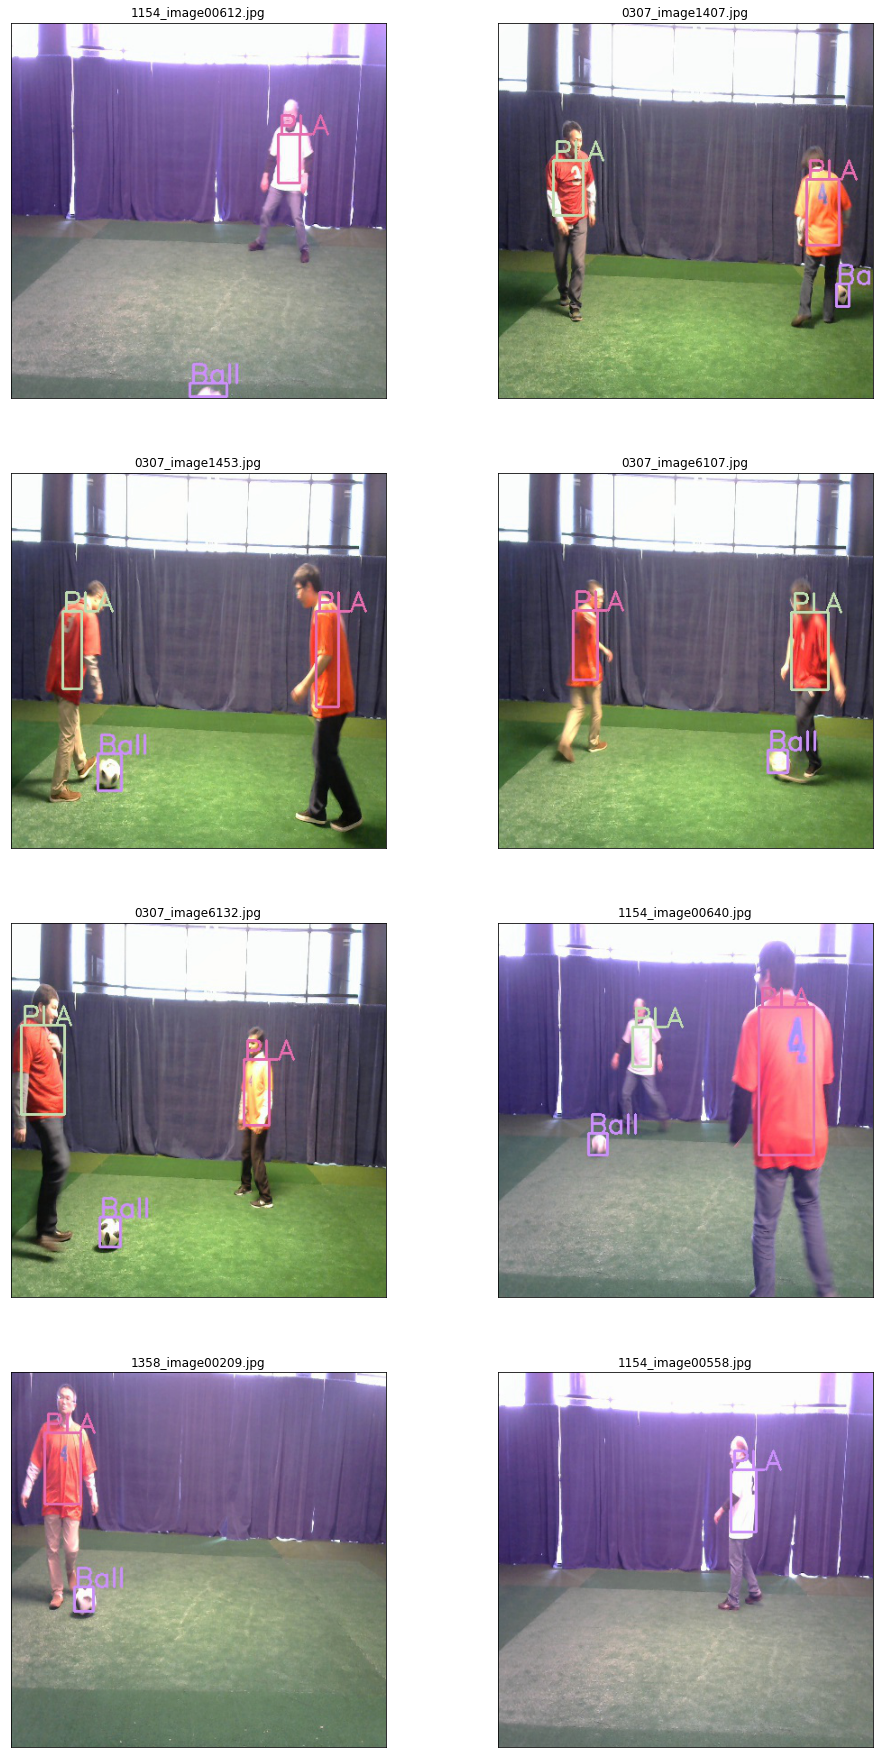

In [23]:
display_object_detections(s, 
                          train_set, 
                          # Use YOLO-type coordinates
                          'yolo', 
                          # 2 detection classes
                          n_col=2, 
                          # display 8 observations
                          num_plot=8)

Each of the training images displayed shows up to 3 detected objects with class labels of either "Ball" (ball) or "PLA" (player). The training data table looks good. Now it is time to load the pre-trained model weights that were downloaded earlier into SAS CAS. 

<a id="loadWeights"></a>

### Load Pretrained Model Weights into SAS CAS

Load the pretrained model weights that you downloaded earlier into the SAS CAS `rcnn` caslib:


In [24]:
# Load the pre-trained model weights, attributes, and labels
s.table.loadtable(casout={'name':'VGG16_YOLO_Weights_Attrs_Labels1','replace':True}, 
                  caslib='rcnn',
                  path="VGG16_YOLO_Weight_Attr_Label.sashdat")
s.table.loadtable(casout={'replace':True}, 
                  caslib='rcnn',
                  path='VGG16_YOLO_Attr_Full_Labels.sashdat')
s.table.attribute(name='VGG16_YOLO_Weights_Attrs_Labels1',
                  table='VGG16_YOLO_Attr_Full_Labels')
# Use 'set_weights()' to load the weights 
# for the FastRCNN model 'soccer'  
soccer.set_weights('VGG16_YOLO_Weights_Attrs_Labels1')

NOTE: Cloud Analytic Services made the file VGG16_YOLO_Weight_Attr_Label.sashdat available as table VGG16_YOLO_WEIGHTS_ATTRS_LABELS1 in caslib CASUSER(userID).
NOTE: Cloud Analytic Services made the file VGG16_YOLO_Attr_Full_Labels.sashdat available as table VGG16_YOLO_ATTR_FULL_LABELS in caslib CASUSER(userID).
NOTE: Model weights attached successfully!


<a id="defineTargetCols"></a>

### Define and Create Target Columns for the Test Data

The test data set for this notebook is a collection of images. While the test data was extracted from the same data set as the training data, the columns that contained object detection metadata (object location, object bounding box, object label) were not included. 

In order to score the table, the FasterRCNN model needs columns to contain the scored detected object data. The _coordType_ variable setting below configures the test data table for YOLO-style object coordinates and column headings. 

In [25]:
# Define notebook variables, input, and 
# output column headings for the model.

# max number of labeled targets to read per image
maxDet = 3;

# Use coordType value ==2 to choose target column headings

# Fails type 1 test
if coordType == 1:
    coordColumnStrList = ["xmin", "ymin", "xmax", "ymax"]      
    
else:
# Selects these column headings. 
# They use YOLO-type coordinates.
    coordColumnStrList = ["x", "y", "width", "height"]
# Number of targets for each image stored in _nObjects_
    targets = ['_nObjects_'];
# Object data for up to 3 instances
for i in range(0,maxDet):
    targets.append('_Object%d_'%i)
    for sp in coordColumnStrList:
        targets.append ('_Object%d_%s'%(i, sp))

# Declare the single input '_image_' column        
inputVars = ['_image_']

<a id="trainModel"></a>

### Train the FasterRCNN Model 

Now use the SAS DLPy _fit()_ function to train the SAS Viya FasterRCNN model `soccer` with the following model parameter settings:


In [26]:
# Train the FasterRCNN model 'soccer'.

# gpus
gpus = Gpu(devices=[0])

# optimizer parameter settings
optimizer=Optimizer(mini_batch_size=2, 
                    algorithm=MomentumSolver(learning_rate=0.0001),
                    log_level=5, 
                    max_epochs=1, 
                    reg_l2=0.0001)
# input data specs
data_specs = [DataSpec(type_='IMAGE', 
                       layer='data', 
                       data=inputVars), 
              DataSpec(type_='OBJECTDETECTION', 
                       layer='rois', 
                       data=targets)]

# fit the model training data
soccer.fit(data=train_set, 
          optimizer=optimizer, 
          n_threads=1,
          data_specs=data_specs, 
          gpu=gpus, 
          record_seed=13309)

NOTE: Training based on existing weights.
NOTE: The forward, fit and loss error, and backward operations of the layer 'rois' are performed on CPU.
NOTE: The forward operation of the layer 'roi_pooling' is performed on CPU.
NOTE: The backward operation of the layer 'roi_pooling' is performed on CPU.
NOTE: The forward, fit and loss error, and backward operations of the layer 'fastrcnn' are performed on CPU.
NOTE: Using your-host-name.unx.company.com: 1 out of 2 available GPU devices.
NOTE: your-host-name.unx.company.com: GPU 0 processes up to 2 records at a time.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 136709509.
NOTE:  The approximate memory cost is 4259.00 MB.
NOTE:  Loading weights cost       7.61 (s).
NOTE:  Initializing each layer cost       7.76 (s).
NOTE:  The total number of threads on each worker is 1.
NOTE:  The total mini-batch size per thread on each worker is 2.
NOTE:  The maximum mini-batch size across all workers for the synchronous mod

[ModelInfo]

                                         Descr                         Value
 0                                  Model Name                   faster_rcnn
 1                                  Model Type  Convolutional Neural Network
 2                            Number of Layers                            27
 3                      Number of Input Layers                             1
 4                     Number of Output Layers                             0
 5              Number of Convolutional Layers                            15
 6                    Number of Pooling Layers                             4
 7            Number of Fully Connected Layers                             4
 8            Number of Region Proposal Layers                             1
 9                Number of RoI Pooling Layers                             1
 10                  Number of FastRCNN Layers                             1
 11                Number of Weight Parameters                     136696512
 12                  Number of Bias Parameters                         12997
 13           Total Number of Model Parameters                     136709509
 14  Approximate Memory Cost for Training (MB)                          4261

[OptIterHistory]

    Epoch  LearningRate      Loss  FitError    L2Norm
 0      1        0.0001  0.255337  0.062876  0.203984

[OutputCasTables]

             casLib                 Name       Rows  Columns  \
 0  CASUSER(userID)  Faster_RCNN_weights  136709509        3   
 
                                             casTable  
 0  CASTable('Faster_RCNN_weights', caslib='CASUSE...  

+ Elapsed: 1.98e+03s, user: 3.09e+03s, sys: 709s, mem: 4.28e+03mb

<a id="scoreTestData"></a>

### Score the Test Data using FasterRCNN Model     
Now use the trained model `soccer` to score the test data in the partition that was created and named `testSetTbl`:

In [27]:
# Score the test data

soccer.predict(data=testSetTbl, 
              n_threads=1, 
              gpu=gpus, 
              log_level=5, 
              mini_batch_buf_size=2)

NOTE: The forward operation of the layer 'rois' is performed on CPU.
NOTE: The fit and loss error calculation of the layer 'rois' is performed on CPU.
NOTE: The forward operation of the layer 'roi_pooling' is performed on CPU.
NOTE: The forward operation of the layer 'fastrcnn' is performed on CPU.
NOTE: The fit and loss error calculation of the layer 'fastrcnn' is performed on CPU.
NOTE: Using your-host-name.unx.company.com: 1 out of 2 available GPU devices.
NOTE: your-host-name.unx.company.com: GPU 0 processes up to 10 records at a time.
NOTE:  Loading weights cost       4.55 (s).
NOTE:  Initializing each layer cost       4.11 (s).
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error   Time(s) (Validation)
NOTE:      0    10        0                0          0     6.04
NOTE:          LayerID  LayerName  StatsName  Value
NOTE:               20       rois       Loss        0
NOTE:               20       rois    LocLoss        0
NOTE:               20       rois  ClassLoss        0


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read          1372
 1  Number of Observations Used             0

[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(userID)  Valid_Res_egBL8i  1372      302   
 
                                             casTable  
 0  CASTable('Valid_Res_egBL8i', caslib='CASUSER(c...  

+ Elapsed: 290s, user: 417s, sys: 110s, mem: 3.73e+03mb

<a id="showDetected"></a>

#### Show Detected Objects in the Scored Image Data

Now use the SAS DLPy `display_object_detections()` function to display the detected objects in 10 of the scored test data images:

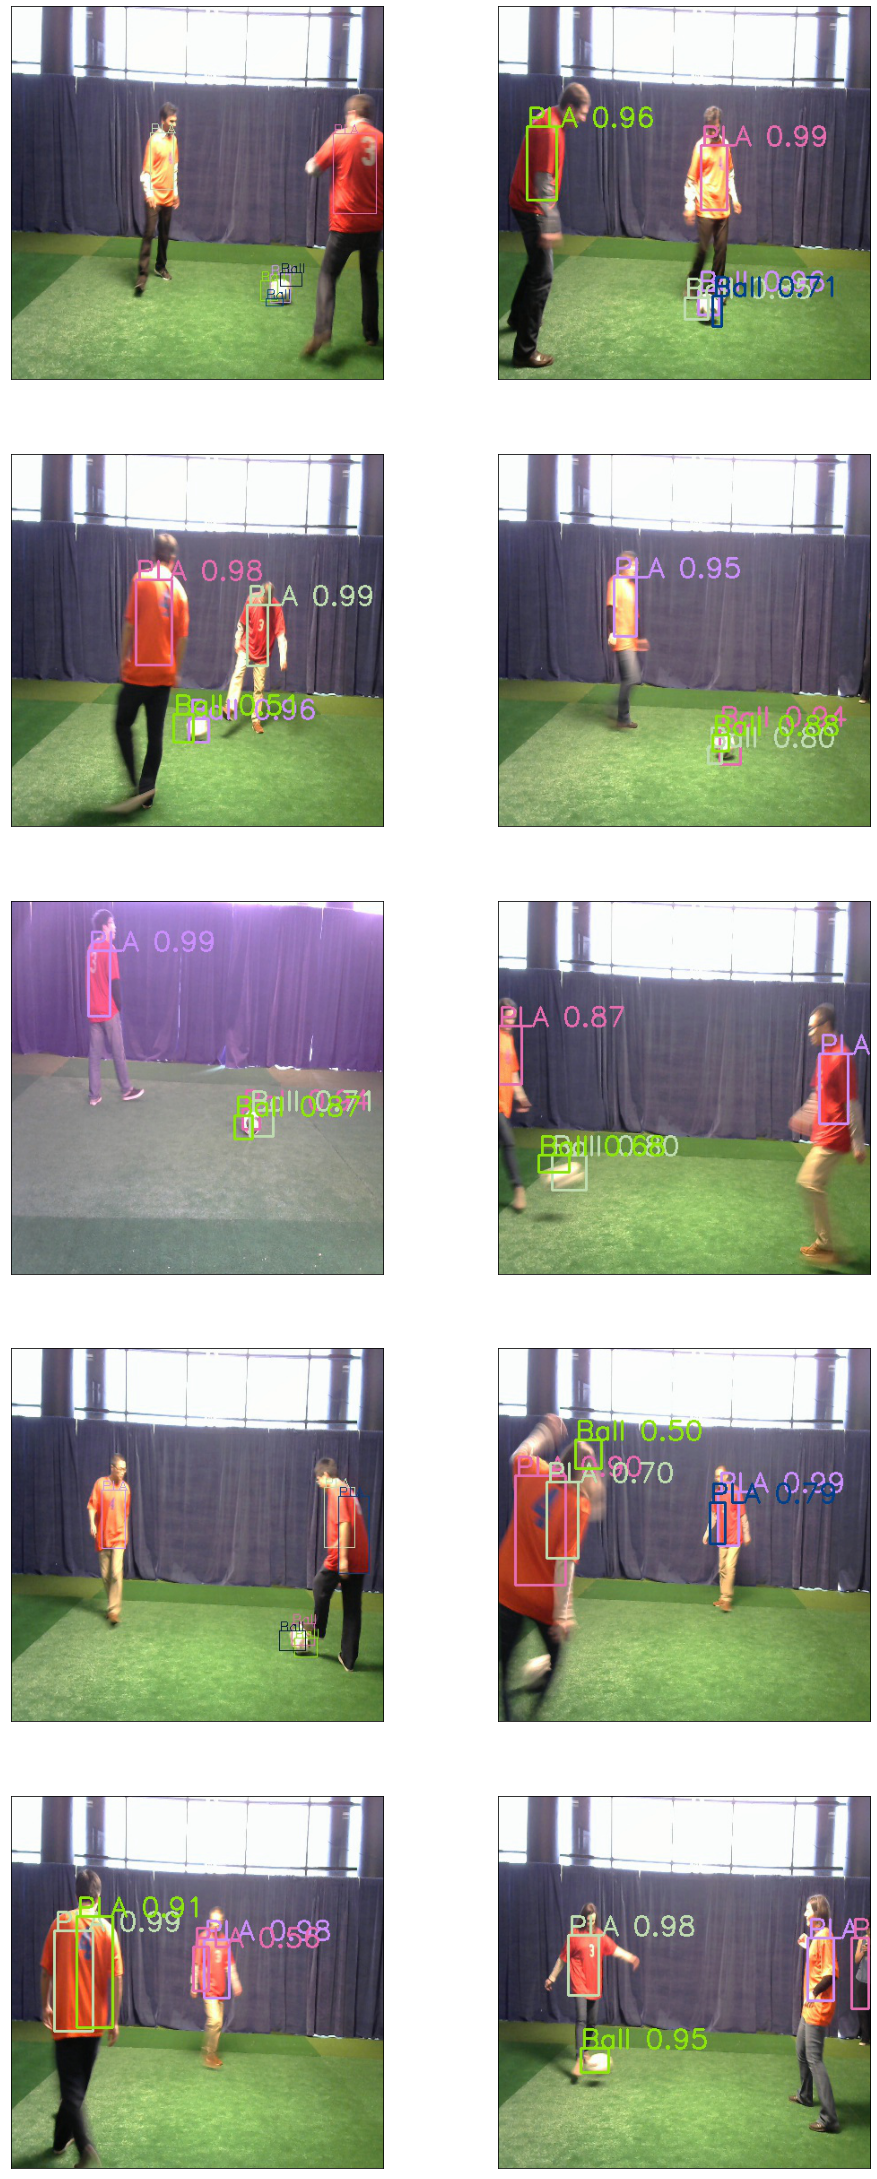

In [28]:
# Display detected objects
display_object_detections(s, 
                          # Results table
                          soccer.valid_res_tbl, 
                          # YOLO-style coordinates
                          'yolo', 
                          # Show 10 scored images 
                          # in 2 display columns
                          num_plot=10, 
                          n_col=2)